In [1]:
# Created: 20201203
using Distributed, SharedArrays
addprocs(12)

12-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13

In [3]:
@everywhere include("code/acoustic_solver_parallel.jl");
@everywhere include("code/acoustic_solver.jl");
@everywhere include("code/adjoint_method_ot.jl")
@everywhere include("code/optimization.jl")
@everywhere include("code/Mixed_Wasserstein.jl")

@everywhere using PyPlot, JLD2, FileIO
# @everywhere using MAT, ImageFiltering

In [4]:
@everywhere function make_model(delta_c,z,Nx,Ny)
    c = ones(Nx,Ny)
    c[z:end,:] .+= delta_c
    return c
end

CFL: 0.35000000000000003
      From worker 13:	CFL: 0.35000000000000003
      From worker 2:	CFL: 0.35000000000000003
      From worker 3:	CFL: 0.35000000000000003
      From worker 7:	CFL: 0.35000000000000003
      From worker 5:	CFL: 0.35000000000000003
      From worker 8:	CFL: 0.35000000000000003
      From worker 4:	CFL: 0.35000000000000003
      From worker 6:	CFL: 0.35000000000000003
      From worker 11:	CFL: 0.35000000000000003
      From worker 9:	CFL: 0.35000000000000003
      From worker 10:	CFL: 0.35000000000000003
      From worker 12:	CFL: 0.35000000000000003


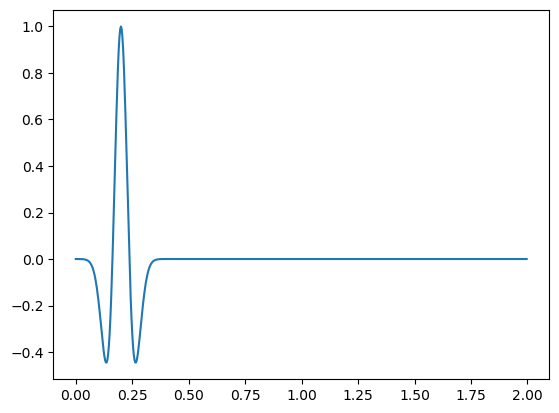

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fec3b11d050>

In [5]:
@everywhere begin
    Nx = 101
    Ny = 101
#     c_true = ones(Nx,Ny)
    c_true = make_model(0.05, 51, Nx, Ny)
    rho = ones(Nx,Ny)
    h = 0.01

    # time
    Fs = 300;
    dt = 1/Fs;
    Nt = 600;
    t = range(0,length=Nt,step=dt);
    println("CFL: ", maximum(c_true) * dt / h);

    # source
    source = source_ricker(6,0.2,t)
    source_num = 1
    source_position = zeros(Int,source_num,2)
    for i = 1:source_num
            source_position[i,:] = [5 51]
    end
    source = repeat(source, 1, 1);

    # receiver
    receiver_num = 11
    receiver_position = zeros(Int,receiver_num,2)
    for i = 1:receiver_num
        receiver_position[i,:] = [1, (i-1)*10+1]
    end

    # PML
    pml_len = 50
    pml_coef = 50;
    
end
plot(t, source[:,1])

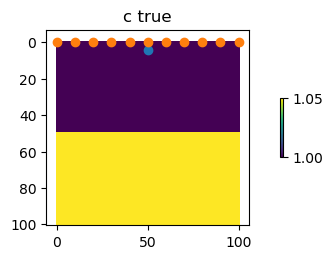

In [6]:
figure
# subplot(211); imshow(c, aspect=1.5); title("c"); colorbar(shrink=0.3); clim(2,5)
# scatter(source_position[:,2].-1, source_position[:,1].-1)
# scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

subplot(212); imshow(c_true); title("c true"); colorbar(shrink=0.3);
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

tight_layout()

In [7]:
@time uu, received_data = acoustic_solver(c_true, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);

  4.611909 seconds (8.21 M allocations: 433.919 MiB, 14.50% gc time)


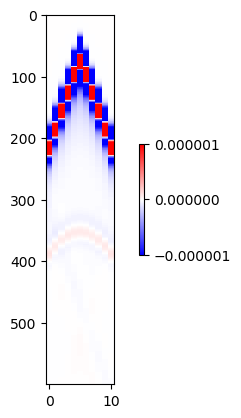

In [8]:
imshow(received_data[:,:], cmap="bwr", aspect=0.1); colorbar(shrink=0.3);
clim([-1e-6,1e-6]);

In [9]:
delta_c = range(-0.1, step=0.005, stop=0.2)
num_delta_c = length(delta_c)
z = 40:60
num_z = length(z)


i = 20
j = 1
cc = make_model(delta_c[i], z[j], Nx, Ny)
data = acoustic_solver_no_wavefield(cc, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);

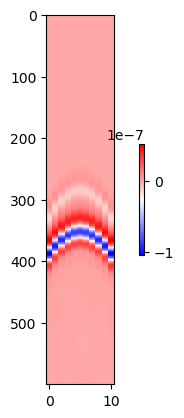

In [10]:
imshow(data-received_data, cmap="bwr", aspect=0.1); colorbar(shrink=0.3);

## UOT

In [12]:
M = cost_matrix_1d(t,t)
reg = 1e-4
reg_m = 1e0
iterMax = 500
k = 5e4
@time dist, adj = adj_source_ot_exp(data, received_data, M; reg=reg, reg_m=reg_m, iterMax=iterMax, k=k);

  1.059644 seconds (22.83 k allocations: 430.328 MiB, 4.57% gc time)


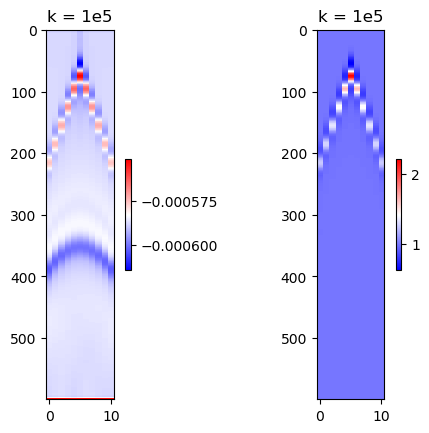

PyObject Text(0.5, 1, 'k = 1e5')

In [13]:
subplot(121)
imshow(adj, cmap="bwr", aspect=0.1); colorbar(shrink=0.3); title("k = 1e5")
subplot(122)
imshow(exp.(k.*data), cmap="bwr", aspect=0.1); colorbar(shrink=0.3); title("k = 1e5")

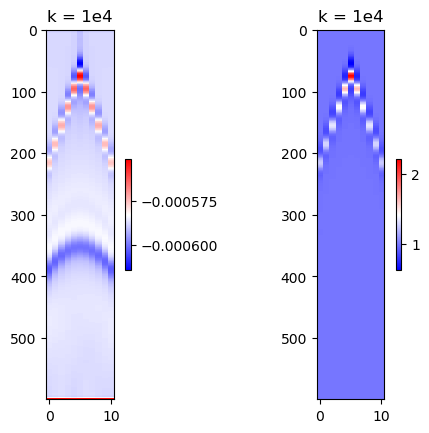

PyObject Text(0.5, 1, 'k = 1e4')

In [14]:
subplot(121)
imshow(adj, cmap="bwr", aspect=0.1); colorbar(shrink=0.3); title("k = 1e4")
subplot(122)
imshow(exp.(k.*data), cmap="bwr", aspect=0.1); colorbar(shrink=0.3); title("k = 1e4")

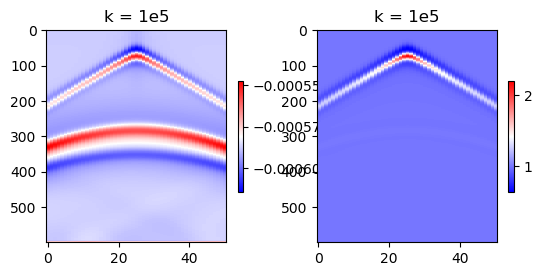

PyObject Text(0.5, 1, 'k = 1e5')

In [20]:
subplot(121)
imshow(adj, cmap="bwr", aspect=0.1); colorbar(shrink=0.3); title("k = 1e5")
subplot(122)
imshow(exp.(k.*data), cmap="bwr", aspect=0.1); colorbar(shrink=0.3); title("k = 1e5")

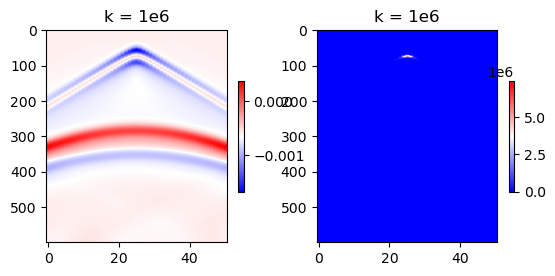

PyObject Text(0.5, 1.0, 'k = 1e6')

In [33]:
subplot(121)
imshow(adj, cmap="bwr", aspect=0.1); colorbar(shrink=0.3); title("k = 1e6")
subplot(122)
imshow(exp.(k.*data), cmap="bwr", aspect=0.1); colorbar(shrink=0.3); title("k = 1e6")

## Mixed Wasserstein

In [15]:
eps = 1e-4
lambda_mix = 1e-8
M = cost_matrix_1d(t, t; p=2)
iteration_number = 500
k_normalize = 5e4

@time dist, adj = adj_source_mixed_tbyt(data, received_data, eps, lambda_mix, M, k_normalize; iter_num=iteration_number);

  2.262934 seconds (3.11 M allocations: 399.552 MiB, 7.99% gc time)


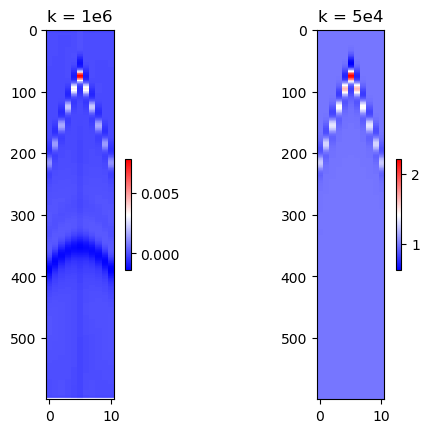

PyObject Text(0.5, 1, 'k = 5e4')

In [16]:
subplot(121)
imshow(adj, cmap="bwr", aspect=0.1); colorbar(shrink=0.3); title("k = 1e6")
subplot(122)
imshow(exp.(k_normalize.*data), cmap="bwr", aspect=0.1); colorbar(shrink=0.3); title("k = 5e4")

## Main experiment

In [17]:

# delta_c = range(-0.15, step=0.01, stop=0.3)
# num_delta_c = length(delta_c)
# z = 55:95
# num_z = length(z)

# misfit_l2 = SharedArray{Float64}(num_delta_c, num_z)
# misfit_uot = SharedArray{Float64}(num_delta_c, num_z)
# misfit_mixed = SharedArray{Float64}(num_delta_c, num_z)

epss = 1e-4
lambda_mix = 1e-8
M = cost_matrix_1d(t, t; p=2)
iteration_number = 500
k_normalize = 5e4

reg = 1e-4
reg_m = 1e0

print("problem size: ")
println(num_delta_c)
println(num_z)
println(num_delta_c * num_z)

@save "wavefield2/data.jld2" delta_c num_delta_c z num_z

problem size: 61
21
1281


In [18]:
# compute the wavefield
print("total c: ")
println(num_delta_c)
@time @sync @distributed for i = 1:num_delta_c
    for j = 1:num_z
        cc = make_model(delta_c[i], z[j], Nx, Ny)
        
        data = acoustic_solver_no_wavefield(cc, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);
        
        file_name = "wavefield2/wavefield_" * string(i) * "_" * string(j) * ".jld2"
        @save file_name data
#         dist1, adj = adj_source_ot_exp(data, received_data, M; reg=reg, reg_m=reg_m, iterMax=iteration_number, k=k_normalize);
#         adj = nothing
        
#         dist2, adj = adj_source_mixed_tbyt(data, received_data, epss, lambda_mix, M, k_normalize; iter_num=iteration_number);
#         adj = nothing
        
#         misfit_l2[i,j] = 0.5*norm(received_data-data,2)^2
#         misfit_uot[i,j] = dist1
#         misfit_mixed[i,j] = dist2
    end
    println(i)
end
# misfit_l2 = Array(misfit_l2)
# misfit_uot = Array(misfit_uot)
# misfit_mixed = Array(misfit_mixed);

total c: 61
      From worker 13:	57
      From worker 5:	17
      From worker 6:	22
      From worker 10:	42
      From worker 7:	27
      From worker 2:	1
      From worker 4:	12
      From worker 9:	37
      From worker 3:	7
      From worker 11:	47
      From worker 8:	32
      From worker 12:	52
      From worker 13:	58
      From worker 6:	23
      From worker 4:	13
      From worker 10:	43
      From worker 5:	18
      From worker 7:	28
      From worker 3:	8
      From worker 2:	2
      From worker 9:	38
      From worker 11:	48
      From worker 8:	33
      From worker 12:	53
      From worker 13:	59
      From worker 6:	24
      From worker 10:	44
      From worker 4:	14
      From worker 7:	29
      From worker 5:	19
      From worker 3:	9
      From worker 9:	39
      From worker 11:	49
      From worker 2:	3
      From worker 8:	34
      From worker 12:	54
      From worker 13:	60
      From worker 6:	25
      From worker 10:	45
      From worker 4:	15
      From worker 3:

In [19]:
@everywhere using FileIO
i = 10
j = 10
file_name = "wavefield2/wavefield_" * string(i) * "_" * string(j) * ".jld2"

dd = load(file_name, "data");

In [20]:
# compute the l2 misfit
print("total c: ")
println(num_delta_c)
misfit_l2 = SharedArray{Float64}(num_delta_c, num_z)

@time @sync @distributed for i = 1:num_delta_c
    for j = 1:num_z
        file_name = "wavefield2/wavefield_" * string(i) * "_" * string(j) * ".jld2"

        data = load(file_name, "data");
        misfit_l2[i,j] = 0.5*norm(received_data-data,2)^2
    end
#     println(i);
end
misfit_l2 = Array(misfit_l2);

total c: 61
  6.969220 seconds (790.00 k allocations: 40.806 MiB)


In [21]:
using3D()
xgrid = repeat(delta_c,1,num_z)
ygrid = repeat(z',num_delta_c,1);

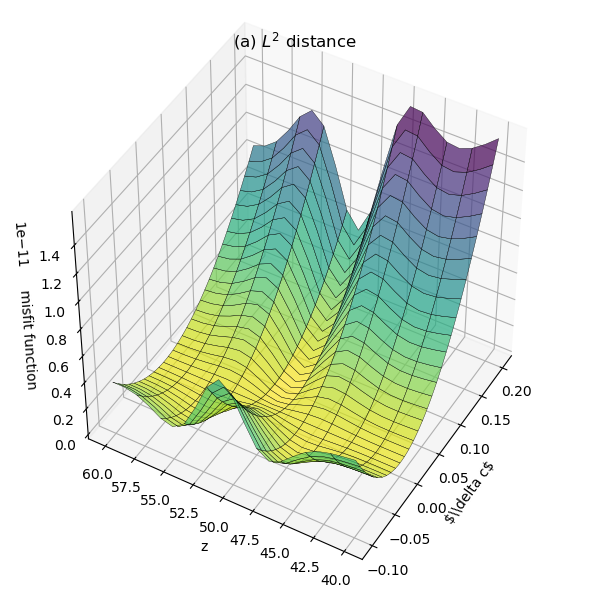

In [22]:
fig = figure("pyplot_surfaceplot",figsize=(6,6))

ax = fig.add_subplot(1,1,1,projection="3d")
plot_surface(xgrid, ygrid, misfit_l2, rstride=2, edgecolors="k", cstride=2, cmap=ColorMap("viridis_r"), alpha=0.7, linewidth=0.25)
ylabel("z"); xlabel(L"$\\delta c\$"); zlabel("misfit function"); title("(a) \$L^2\$ distance")
ax.view_init(45, 210)

tight_layout()

In [23]:
# compute the uot misfit
print("total c: ")
println(num_delta_c)
misfit_uot = SharedArray{Float64}(num_delta_c, num_z)

# @time @sync @distributed for i = 1:1
@time @sync @distributed for i = 1:num_delta_c
    for j = 1:num_z
        file_name = "wavefield2/wavefield_" * string(i) * "_" * string(j) * ".jld2"
        data = load(file_name, "data");
        
        dist1, adj = adj_source_ot_exp(data, received_data, M; reg=reg, reg_m=reg_m, iterMax=iteration_number, k=k_normalize);
        adj = nothing
        
        misfit_uot[i,j] = dist1
    end
    println(i)
end
misfit_uot = Array(misfit_uot);

total c: 61
      From worker 6:	22
      From worker 13:	57
      From worker 7:	27
      From worker 11:	47
      From worker 2:	1
      From worker 3:	7
      From worker 12:	52
      From worker 5:	17
      From worker 10:	42
      From worker 9:	37
      From worker 8:	32
      From worker 4:	12
      From worker 13:	58
      From worker 6:	23
      From worker 7:	28
      From worker 11:	48
      From worker 5:	18
      From worker 2:	2
      From worker 3:	8
      From worker 12:	53
      From worker 10:	43
      From worker 9:	38
      From worker 8:	33
      From worker 4:	13
      From worker 13:	59
      From worker 6:	24
      From worker 7:	29
      From worker 11:	49
      From worker 3:	9
      From worker 2:	3
      From worker 5:	19
      From worker 12:	54
      From worker 9:	39
      From worker 10:	44
      From worker 8:	34
      From worker 4:	14
      From worker 13:	60
      From worker 6:	25
      From worker 7:	30
      From worker 11:	50
      From worker 3:

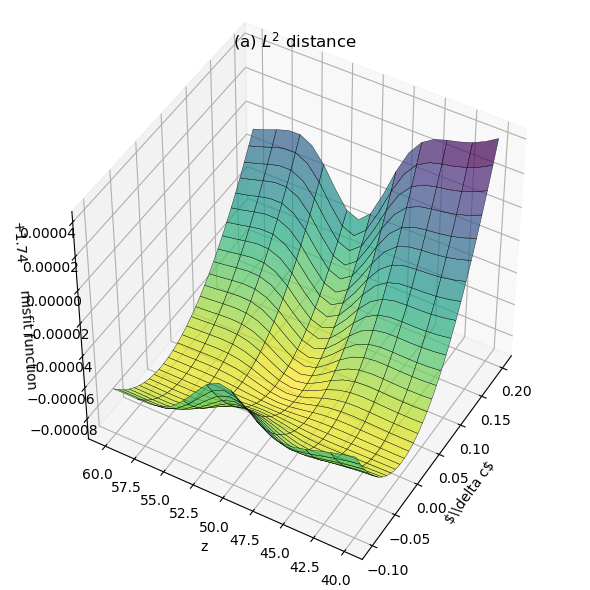

In [24]:
fig = figure("pyplot_surfaceplot",figsize=(6,6))

ax = fig.add_subplot(1,1,1,projection="3d")
plot_surface(xgrid, ygrid, misfit_uot, rstride=2, edgecolors="k", cstride=2, cmap=ColorMap("viridis_r"), alpha=0.7, linewidth=0.25)
ylabel("z"); xlabel(L"$\\delta c\$"); zlabel("misfit function"); title("(a) \$L^2\$ distance")
ax.view_init(45, 210)

tight_layout()

In [25]:
# compute the uot misfit
print("total c: ")
println(num_delta_c)
misfit_mixed = SharedArray{Float64}(num_delta_c, num_z)

# @time @sync @distributed for i = 1:1
@time @sync @distributed for i = 1:num_delta_c
    for j = 1:num_z
        file_name = "wavefield2/wavefield_" * string(i) * "_" * string(j) * ".jld2"
        data = load(file_name, "data");
        
        dist2, adj = adj_source_mixed_tbyt(data, received_data, epss, lambda_mix, M, k_normalize; iter_num=iteration_number);
        adj = nothing
        
        misfit_mixed[i,j] = dist2
    end
    println(i)
end
misfit_mixed = Array(misfit_mixed);

total c: 61
      From worker 13:	57
      From worker 11:	47
      From worker 3:	7
      From worker 5:	17
      From worker 6:	22
      From worker 7:	27
      From worker 12:	52
      From worker 8:	32
      From worker 10:	42
      From worker 2:	1
      From worker 4:	12
      From worker 9:	37
      From worker 13:	58
      From worker 3:	8
      From worker 5:	18
      From worker 11:	48
      From worker 7:	28
      From worker 6:	23
      From worker 12:	53
      From worker 8:	33
      From worker 10:	43
      From worker 2:	2
      From worker 9:	38
      From worker 4:	13
      From worker 13:	59
      From worker 5:	19
      From worker 3:	9
      From worker 6:	24
      From worker 7:	29
      From worker 12:	54
      From worker 11:	49
      From worker 10:	44
      From worker 8:	34
      From worker 2:	3
      From worker 9:	39
      From worker 4:	14
      From worker 13:	60
      From worker 5:	20
      From worker 3:	10
      From worker 6:	25
      From worker 7:	

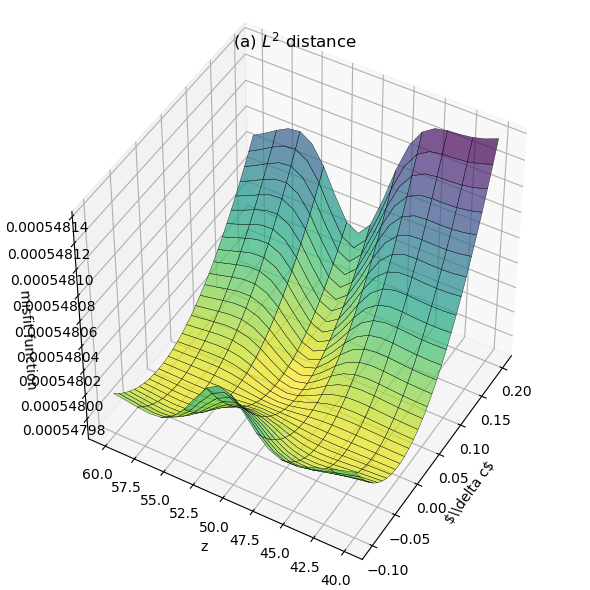

In [26]:
fig = figure("pyplot_surfaceplot",figsize=(6,6))

ax = fig.add_subplot(1,1,1,projection="3d")
plot_surface(xgrid, ygrid, misfit_mixed, rstride=2, edgecolors="k", cstride=2, cmap=ColorMap("viridis_r"), alpha=0.7, linewidth=0.25)
ylabel("z"); xlabel(L"$\\delta c\$"); zlabel("misfit function"); title("(a) \$L^2\$ distance")
ax.view_init(45, 210)

tight_layout()

In [27]:
@save "wavefield2/data.jld2" c_true delta_c num_delta_c z num_z misfit_l2 misfit_uot misfit_mixed 

In [55]:
num_delta_c

31